<a href="https://colab.research.google.com/github/astrohayley/zooniverse-aggregation-notebooks/blob/main/Question_Aggregation_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Aggregation Example

This is an example notebook to help you get started with aggregating your data from Zooniverse. This example works through a question task, but similar steps can be followed for other types of tasks and additional notebooks are currently in development.


If you are new to Colab notebooks, we recommend starting with the Welcome to Colaboratory notebook at https://colab.research.google.com/.

You'll be able to run this notebook as an example, but to use it as a template for your project, you'll need to go to `File→Save a Copy in Drive` or `File→Save a Copy in GitHub` to edit and run it as your own.


## Installing Packages and Configuration

First, we'll need to install the necessary packages using `pip`. If you run this notebook in Google Colab, you'll need to install these each time you run this notebook. If you download and run it on your system, they can be installed only once.

In [ ]:
!pip install -U numpy scipy matplotlib tqdm panoptes_client "git+https://github.com/zooniverse/aggregation-for-caesar.git"

Next, we can import necessary packages:

In [5]:
# basics
import numpy as np
import pandas as pd
import getpass
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import json
import os


# Zooniverse tools
from panoptes_client import Panoptes, Workflow
from panoptes_aggregation.extractors.utilities import annotation_by_task
from panoptes_aggregation.extractors import question_extractor, survey_extractor, all_tasks_empty_extractor
from panoptes_aggregation.reducers import question_consensus_reducer

## Project Set Up

The cells in this section are the most important for specifying details for your own project. We have provided example data for you, however you can fill your own information in to run this notebook for your own project.

Here you'll log into Zooniverse in order to download data. You'll need to log in with you username and password that has access to the appropriate projects. If you're just running this with the example data, you can skip logging in.

In [6]:
client = Panoptes.client(username=getpass.getpass('username: '), password=getpass.getpass('password: '))

username: ··········
password: ··········


Next, you'll enter in the workflow number here for the project you want to analyze. This can be found under the Workflows section on the project builder page. Each workflow name is accompanied by a workflow number directly next to it.

In [7]:
WORKFLOW_ID = 21818

Lastly, enter in the file names of where you'd like to store the raw classification and aggregated data. The filenames we're using below are appropriate for the example data but you can change them to fit your needs.

In [8]:
CLASSIFICATION_FILE = 'jovian-vortex-hunter-classifications.csv'
AGGREGATED_FILE = 'jovian-vortex-hunter-aggregated.csv'

## Downloading Raw Classifications

The first step is to download the raw classifications from Zooniverse. This notebook gives you two options. You can use example data from Jovian Vortex Hunter to run this notebook or you can download your own data from your Zooniverse project.

If you'd like to do the former, run the cells under `Downloading Example Data`. If you'd like to connect to Zooniverse and download your own data, run the cells under `Downloading Your Project Data`.

### Downloading Example Data
The line below will download the example classification data for this demo. Note, the file downloaded is 1.09 GB and will require a stable internet connection.

If you instead want to download your own data, skip the next cell and instead follow the direction under **Downloading Your Project Data**.

In [9]:
!wget -q -nc -O jovian-vortex-hunter-classifications.csv "https://www.dropbox.com/scl/fi/ph1b0zng30l9yp14a1ahj/jovian-vortex-hunter-classifications.csv?rlkey=euzgzfqq6sipaxc2r2qpxajgf&dl=0"

In [11]:
classification_data = pd.read_csv(CLASSIFICATION_FILE)

### Downloading Your Project Data

Below, we show how we can download the raw classifications from Zooniverse for a specific workflow. This can take awhile depending on the size of the project. For that reason, this saves the downloaded classifications into a CSV file, so it can be loaded in next time. If you're using Google Colab, downloaded files do not persist so it is recommended to download the file and re-upload if no additional classifications have been added. Or, if you download this file as a Jupyter Notebook, then saved files can persist on your own machine.

You can also download the raw classifications from your project page. Under the `Data Exports` section, select `Request new workflow classification export`. This will generate the classification data and email you once it is ready to download.

In [10]:
workflow = Workflow(WORKFLOW_ID)

# if it's not already downloaded, then generate the classifications and download them.
if not os.path.isfile(CLASSIFICATION_FILE):

    # connect to client to download classification file
    with client:
        classification_export = workflow.get_export('classifications', generate=True, wait=True)
        classification_rows = [row for row in tqdm(classification_export.csv_dictreader())]

    classification_data = pd.DataFrame.from_dict(classification_rows)

    # save a version locally
    classification_data.to_csv(CLASSIFICATION_FILE, index=False)

# load the local file
classification_data = pd.read_csv(CLASSIFICATION_FILE)

## A Quick Look at the Raw Classification Data
Let's take a moment to look at what these raw classifications look like. We are going to be interacting with our classification data using [Pandas](https://pandas.pydata.org/docs/index.html) dataframes. [Here is an introduction to working with dataframes](https://realpython.com/pandas-dataframe/), however the cells below will demonstrate how to do many basic things with dataframes.

In summary, each row in this dataframe represents one volunteer-submitted annotation for one subject. Each subject will have multiple rows that we will aggregate later in this notebook.

The columns in the classification data may vary depending on your exact project, but here's a rough overview of the most common columns:
- `classification_id` - unique identifier for each classification submitted for your project
- `user_name` and `user_id` - information about the user who submitted the classification
- `workflow_id`, `workflow_name`, and `workflow_version` - information about your workflow
- `created_at` - the date and time the classification was submitted
- `metadata` - general context about the user's environment when submitting the classification, such as what kind of browser, when the user started and finished their classification, etc.
- `annotations` - this is the actual user submitted information that we will be extracting below to aggregate our data
- `subject_data` and `subject_ids` - information about the subject(s) for that classification


Ok, with that out of the way, let's dive into our data! First, we can use the `describe` method to summarize stats in our dataframe:

In [12]:
classification_data.describe()

,Unnamed: 0,classification_id,user_id,workflow_id,workflow_version,gold_standard,expert,subject_ids
count,677785.000000,6.777850e+05,5.518220e+05,677785.0,677785.000000,0.0,0.0,6.777850e+05
mean,338892.000000,4.311869e+08,2.068901e+06,21818.0,1.150000,NaN,NaN,7.763471e+07
std,195659.820439,1.485891e+07,7.735821e+05,0.0,0.000304,NaN,NaN,2.135863e+05
min,0.000000,4.218565e+08,8.000000e+00,21818.0,1.150000,NaN,NaN,7.728865e+07
25%,169446.000000,4.241550e+08,1.981123e+06,21818.0,1.150000,NaN,NaN,7.733104e+07
50%,338892.000000,4.264953e+08,2.485275e+06,21818.0,1.150000,NaN,NaN,7.774548e+07
75%,508338.000000,4.317515e+08,2.491259e+06,21818.0,1.150000,NaN,NaN,7.778869e+07
max,677784.000000,5.212547e+08,2.672026e+06,21818.0,1.400000,NaN,NaN,7.782028e+07


### Example Stats

Here's some examples of the stats we can extract from our data:

In [13]:
unique_counts = classification_data.nunique()

print('Number of classifications:', unique_counts['classification_id'])
print('Number of unique users:',unique_counts['user_name'])
print('Avg classification per user:', np.round(unique_counts['classification_id']/unique_counts['user_name'],2))


Number of classifications: 677785
Number of unique users: 6380
Avg classification per user: 106.24


In [14]:
classifications_per_user = classification_data['user_name'].value_counts()

print('Number of users that submitted only one classification:', sum(classifications_per_user==1))
print('Number of users that submitted more than 100 classifications:', sum(classifications_per_user>100))

Number of users that submitted only one classification: 436
Number of users that submitted more than 100 classifications: 1145


### Accessing Individual Classifications

We can access specific rows by the row index using `iloc`. Below shows an example that looks at the first 5 rows, and some other examples are shown in the comments as well.

In [15]:
# classification_data.iloc[0]  # accesses the first row
# classification_data.iloc[-3] # accesses the third to last row
classification_data.iloc[0:5]  # accesses the first five rows

,Unnamed: 0,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,0,421856454,ramanakumars,2245813.0,5afe26bec1eef3b1dc54,21818,Is there a vortex?,1.40,2022-06-17 05:51:41 UTC,NaN,NaN,"{""source"":""api"",""session"":""2c13184135e240be837...","[{""task"":""T0"",""task_label"":""Identify the featu...","{""77289776"":{""retired"":{""id"":103867722,""workfl...",77289776
1,1,422339725,Cevin,2424342.0,c33f0d1b0c0ee7154051,21818,Is there a vortex?,1.15,2022-06-20 19:15:08 UTC,NaN,NaN,"{""source"":""api"",""session"":""c73f2c203d92d5d8e71...","[{""task"":""T0"",""task_label"":""Identify the featu...","{""77291436"":{""retired"":{""id"":103866937,""workfl...",77291436
2,2,422339758,Cevin,2424342.0,c33f0d1b0c0ee7154051,21818,Is there a vortex?,1.15,2022-06-20 19:15:16 UTC,NaN,NaN,"{""source"":""api"",""session"":""c73f2c203d92d5d8e71...","[{""task"":""T0"",""task_label"":""Identify the featu...","{""77289477"":{""retired"":{""id"":103867165,""workfl...",77289477
3,3,422339864,Cevin,2424342.0,c33f0d1b0c0ee7154051,21818,Is there a vortex?,1.15,2022-06-20 19:15:47 UTC,NaN,NaN,"{""source"":""api"",""session"":""c73f2c203d92d5d8e71...","[{""task"":""T0"",""task_label"":""Identify the featu...","{""77289719"":{""retired"":{""id"":103866052,""workfl...",77289719
4,4,422340289,Cevin,2424342.0,c33f0d1b0c0ee7154051,21818,Is there a vortex?,1.15,2022-06-20 19:17:37 UTC,NaN,NaN,"{""source"":""api"",""session"":""c73f2c203d92d5d8e71...","[{""task"":""T0"",""task_label"":""Identify the featu...","{""77289390"":{""retired"":{""id"":103865331,""workfl...",77289390


## Extracting Volunteer Annotations

Now that you have the raw classification data downloaded, let's extract the annotations submitted by the volunteers. The workflow for the example data asked volunteers to identify features in clouds - an example is shown below:

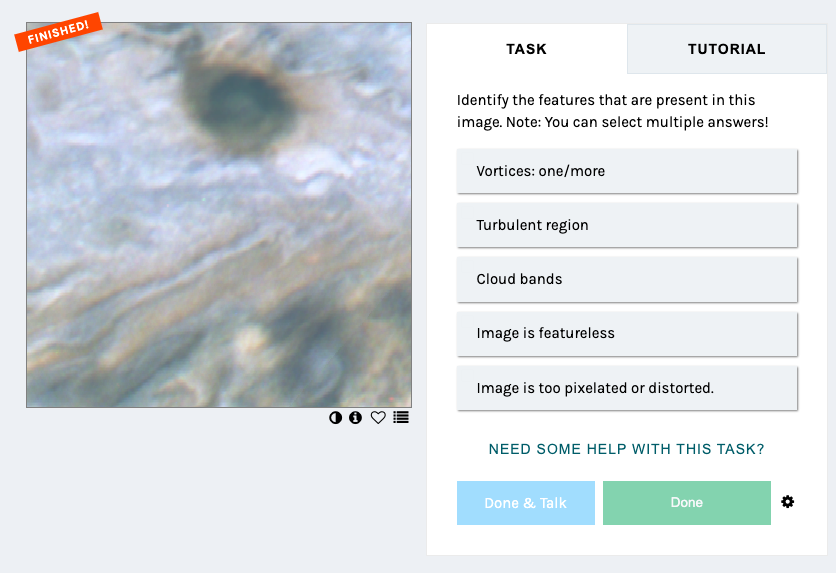

An example cell showing what the volunteer submitted answers look like is shown below.

Notably, the volunteer annotations are stored as strings in dataframe using `json.dumps(extract)` since storing dictionaries is not recommended. This can be easily converted back to a typical dictionary using `json.loads(extract)`, which is shown later in this notebook.

In [16]:
# set up our list where we will store the extracted data temporarily
extracted_rows = []

# iterate through our classification data
for i in trange(len(classification_data)):

    # access the specific row and extract the annotations
    row = classification_data.iloc[i]
    row_annotation = annotation_by_task({'annotations': json.loads(row.annotations)})
    extract = question_extractor(row_annotation)

    # add the extracted annotations to our temporary list along with some other additional data
    extracted_rows.append({
        'classification_id': row.classification_id,
        'subject_id':        row.subject_ids,
        'user_name':         row.user_name,
        'user_id':           row.user_id,
        'created_at':        row.created_at,
        'data':              json.dumps(extract)
        })

# convert the extracted data to a pandas dataframe and sort
extract_data = pd.DataFrame.from_dict(extracted_rows)
extract_data.sort_values(['subject_id', 'created_at'], inplace=True)

100%|██████████| 677785/677785 [03:39<00:00, 3082.86it/s]


In [17]:
# example data showing how a volunteer selected the 'Vortices: one/more' and 'Turbulent region' in the example image above
json.loads(extract_data.iloc[0]['data'])

{'vortices-one-more': 1, 'turbulent-region': 1, 'aggregation_version': '4.1.0'}

## Aggregating Data

Now that we have a table with each classification made by each volunteer, we want to aggregate the data. In addition, we have created a convenient functions for achieving this called `last_filter`, which finds the most up-to-date annotations for the particular case where a volunteer might update their answer after already submitting for a given subject. This code will also utilize the `question_consensus_reducer` from `panoptes_aggregation` ([documentation can be found here](https://aggregation-caesar.zooniverse.org/docs)), which takes the extracted data and determines the most common result and agreement fraction of all the volunteer submitted data.

In [18]:
# determine the most recently submitted classifications
def last_filter(data):
    last_time = data.created_at.max()
    ldx = data.created_at == last_time
    return data[ldx]

In [19]:
# generate an array of unique subject ids - these are the ones that we will iterate over
subject_ids_unique = np.unique(extract_data.subject_id)

# set up a temporary list to store reduced data
aggregated_rows = []

# iterating over each unique subject id
for i in trange(len(subject_ids_unique)):

    # determine the subject_id to work on
    subject_id = subject_ids_unique[i]

    # filter the extract_data dataframe for only the subject_id that is being worked on
    extract_data_filtered = extract_data[extract_data.subject_id==subject_id].drop_duplicates()

    # if there are less unique user submissions than classifications, filter for the most recently updated classification
    if (len(extract_data_filtered.user_name.unique()) < len(extract_data_filtered)):
        extract_data_filtered = extract_data_filtered.groupby(['user_name'], group_keys=False).apply(last_filter)

    # iterate through the filtered extract data to prepare for the reducer
    classifications_to_reduce = [json.loads(extract_data_filtered.iloc[j].data) for j in range(len(extract_data_filtered))]

    # use the Zooniverse question_consesus_reducer to get the final consensus
    reduction = question_consensus_reducer(classifications_to_reduce)

    # add the subject id to our reduction data
    reduction['subject_id'] = subject_id

    # add the data to our temporary list
    aggregated_rows.append(reduction)


# converting the result to a dataframe
aggregated_data = pd.DataFrame.from_dict(aggregated_rows)


100%|██████████| 68322/68322 [05:53<00:00, 193.43it/s]


In [20]:
# save the reduced data as a csv
aggregated_data.to_csv(AGGREGATED_FILE, index=False)

In [21]:
# can be read later using:
aggregated_data = pd.read_csv(AGGREGATED_FILE)

## Analyzing Aggregated Data

The exact process for analyzing the aggregated data will vary based on the team, project, and goals of the analysis. Here, we show a few examples of what you can do.

### Specific Subject Query

Here's what `aggregated_data` looks like in its current state.

In [22]:
# with the original index
aggregated_data

,most_likely,num_votes,agreement,aggregation_version,subject_id
0,turbulent-region,7,0.538462,4.1.0,77288647
1,vortices-one-more,7,0.538462,4.1.0,77288648
2,vortices-one-more,7,0.500000,4.1.0,77288649
3,vortices-one-more,6,0.428571,4.1.0,77288650
4,turbulent-region,5,0.357143,4.1.0,77288651
...,...,...,...,...,...
68317,cloud-bands,7,0.500000,4.1.0,77820273
68318,cloud-bands,5,0.384615,4.1.0,77820274
68319,cloud-bands,6,0.500000,4.1.0,77820275
68320,image-is-featureless,7,0.636364,4.1.0,77820276


However, we can set the index of the dataframe to be the `subject_id`. This allows us to easily look up the results for a given subject:

In [23]:
# update the index
aggregated_data.set_index('subject_id', inplace=True)

In [24]:
# getting the results for the subject id 77820273
aggregated_data.loc[77820273]

most_likely            cloud-bands
num_votes                        7
agreement                      0.5
aggregation_version          4.1.0
Name: 77820273, dtype: object

### Plotting General Results

Below, we show how you can make some potentially interesting plots based on your data.

First, a basic histogram showing the number of annotations each subject received:

Text(0, 0.5, 'Number of Subjects')

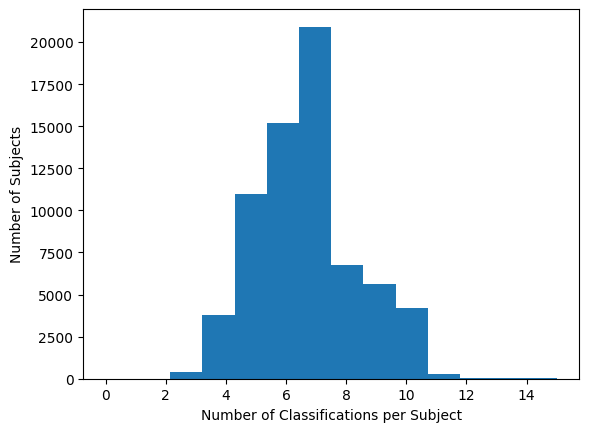

In [25]:
plt.hist(aggregated_data['num_votes'], bins=np.linspace(0,15,15))
plt.xlabel('Number of Classifications per Subject')
plt.ylabel('Number of Subjects')

Next, let's look at the range of agreement values:

Text(0, 0.5, 'Number of Subjects')

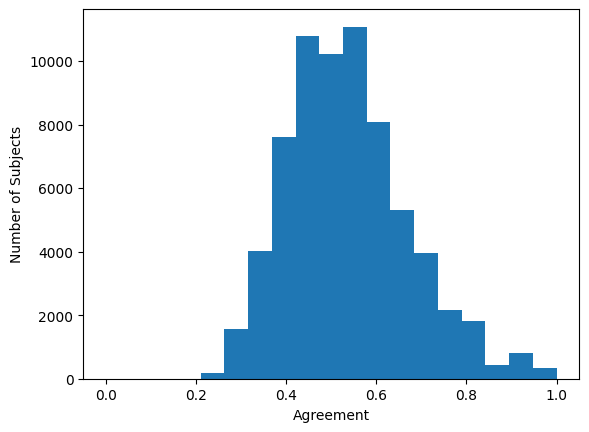

In [26]:
plt.hist(aggregated_data['agreement'], bins=np.linspace(0,1,20))
plt.xlabel('Agreement')
plt.ylabel('Number of Subjects')

We can also filter our data so that it only plots those with 5 or more annotations

Text(0, 0.5, 'Number of Subjects')

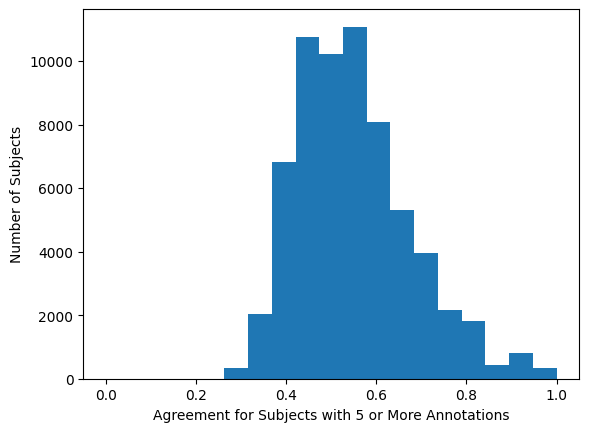

In [27]:
plt.hist(aggregated_data[aggregated_data.num_votes >= 5]['agreement'], bins=np.linspace(0,1,20))
plt.xlabel('Agreement for Subjects with 5 or More Annotations')
plt.ylabel('Number of Subjects')

Lastly, pandas dataframes have some handy plotting functions built in. Let's plot histograms based on each available option:

array([<Axes: title={'center': 'cloud-bands'}, ylabel='Frequency'>,
       <Axes: title={'center': 'image-is-featureless'}, ylabel='Frequency'>,
       <Axes: title={'center': 'image-is-too-pixelated-or-distorted'}, ylabel='Frequency'>,
       <Axes: title={'center': 'turbulent-region'}, ylabel='Frequency'>,
       <Axes: title={'center': 'vortices-one-more'}, ylabel='Frequency'>],
      dtype=object)

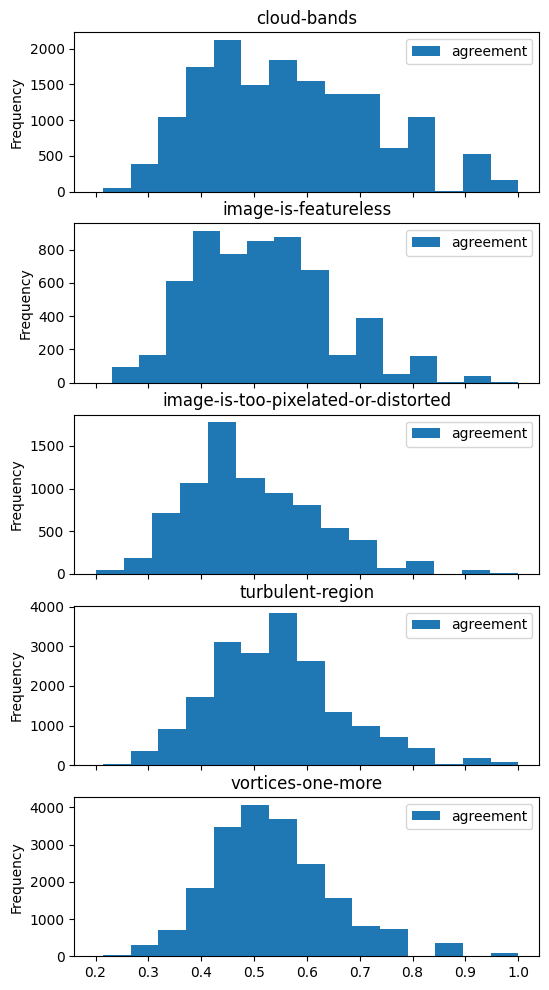

In [28]:
aggregated_data.plot.hist(column=['agreement'], by='most_likely', bins=15, figsize=(6, 12), sharex=True)